In [1]:
%load_ext autoreload
%autoreload 2

**Installing necessary packages**

In [2]:
import shutil
import glob
import os
from multiprocessing.pool import ThreadPool
# from tqdm.notebook import tqdm # TODO ask Kristin to add?

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

# datalabs only
# from astroquery.esa.euclid.core import EuclidClass, Euclid

In [3]:
import morphology_utils
import cutout_utils
import pipeline_utils

**Logging in**

In [4]:
# change to your username
# Euclid.login(user='mwalms01')

In [5]:
# segmentation_area = 1200

download_dir = '/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch'

base_cutout_dir = download_dir + '/cutouts'
cutout_folder = base_cutout_dir + '/jpg'

base_tile_dir = download_dir + '/tiles'

base_catalog_dir = download_dir + '/catalogs'


for d in [cutout_folder, base_tile_dir, base_catalog_dir]:
    print(d)
    if not os.path.exists(d):
        os.makedirs(d)

/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch/cutouts/jpg
/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch/tiles
/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch/catalogs


In [6]:
base_catalog_dir

'/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch/catalogs'

In [7]:
# quick check
catalog_locs = glob.glob(base_catalog_dir + '/*_mer_catalog.csv')
print(f'Found {len(catalog_locs)} catalogs')
master_catalog = pd.concat([pd.read_csv(c) for c in catalog_locs], axis=0)
print(f'Found {len(master_catalog)} sources')


Found 94 catalogs
Found 82630 sources


In [8]:
# master_catalog['vis_tile'] = master_catalog['vis_tile'].str.replace('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v2_challenge_launch/tiles', base_tile_dir)
# master_catalog['vis_tile']

In [9]:

# TODO apply any galaxy-level random subselection?
# nah, I think tile-level subselection will be enough. It's clearer to do every relevant source in a given tile. Then we have a list of classified tiles.

master_catalog['jpg_loc_composite'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='composite', oneway_hash=False), axis=1)
master_catalog['jpg_loc_vis_only'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_only', oneway_hash=False), axis=1)
master_catalog['jpg_loc_vis_lsb'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_lsb', oneway_hash=False), axis=1)
master_catalog['fits_loc'] = master_catalog.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder.replace('jpg', 'fits'), x, output_format='fits.gz', version_suffix='fits', oneway_hash=False), axis=1)

master_catalog['vis_tile'] = master_catalog['vis_tile'].apply(lambda x: os.path.join(base_tile_dir, os.path.basename(x)))
master_catalog['y_tile'] = master_catalog['y_tile'].apply(lambda x: os.path.join(base_tile_dir, os.path.basename(x)))
master_catalog['vis_tile_ready'] = master_catalog['vis_tile'].apply(lambda x: os.path.exists(x))
master_catalog['y_tile_ready'] = master_catalog['y_tile'].apply(lambda x: os.path.exists(x))
print(f'Found {master_catalog["vis_tile_ready"].sum()} visual tiles and {master_catalog["y_tile_ready"].sum()} Y tiles')

print(master_catalog[~master_catalog['vis_tile_ready']]['tile_index'].unique())

# master_catalog = master_catalog.query('vis_tile_ready and y_tile_ready')

# also restrict to below 5000px in area, just in case of recognisable galaxies

print(f'{len(master_catalog)} sources after area filter')
master_catalog = master_catalog.query('segmentation_area < 25000')

# master_catalog.to_csv(base_catalog_dir + '/_master_catalog.csv', index=False)  # _ to appear first

Found 0 visual tiles and 0 Y tiles
[102026603 102027661 102016896 102017360 102021511 102042352 102025555
 102028213 102028217 102023999 102013571 102025020 102030408 102035627
 102018254 102020090 102027675 102042351 102034406 102016463 102026063
 102022015 102036819 102032685 102030411 102016036 102021057 102020561
 102031525 102015615 102033246 102027667 102021034 102017361 102025018
 102035034 102013176 102034447 102022002 102013966 102012787 102041725
 102032117 102022990 102021041 102030973 102028753 102022988 102025025
 102019150 102018712 102022013 102021061 102011655 102015620 102030421
 102032104 102031550 102023993 102030968 102032096 102028219 102029879
 102026083 102027664 102025576 102026098 102016054 102019169 102012403
 102034448 102025037 102019633 102033849 102032115 102023521 102028781
 102028782 102028215 102028760 102030405 102026099 102017336 102038026
 102022027 102024506 102030972 102030997 102033263 102012400 102018234
 102034444 102022017 102036817]
82630 sour

In [20]:

unique_df = master_catalog.groupby('tile_index').agg({'right_ascension': 'mean', 'declination': 'mean'}).reset_index()

# construct a non-overlapping set of tiles, to avoid duplication in the overlap area

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='euclidean').fit(unique_df[['right_ascension', 'declination']])

distances, indices = nbrs.kneighbors(unique_df[['right_ascension', 'declination']])
unique_df['nearest_distance'] = distances[:, 1]
unique_df['nearest_index'] = indices[:, 1]

In [21]:
unique_df.sort_values('nearest_distance', ascending=False)

,tile_index,right_ascension,declination,nearest_distance,nearest_index
8,102015620,85.909452,-54.476855,3.053659,5
27,102021061,96.415230,-48.516540,3.000732,26
9,102016036,78.195740,-53.986815,2.634412,11
24,102021034,76.229391,-48.486807,2.424531,29
7,102015615,81.728074,-54.511209,2.374561,6
...,...,...,...,...,...
21,102019633,92.380671,-50.007340,0.531533,20
12,102016896,73.941930,-53.002634,0.507541,13
13,102017336,73.918376,-52.495641,0.507541,12
69,102030972,75.379273,-38.992473,0.503463,66


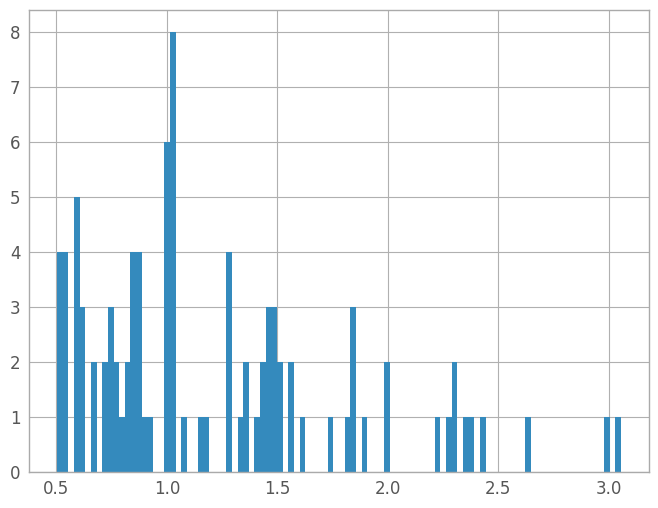

In [23]:
_ = plt.hist(unique_df['nearest_distance'], bins=100)  # 0.5ish is touching, 0.71ish is touching diagonally

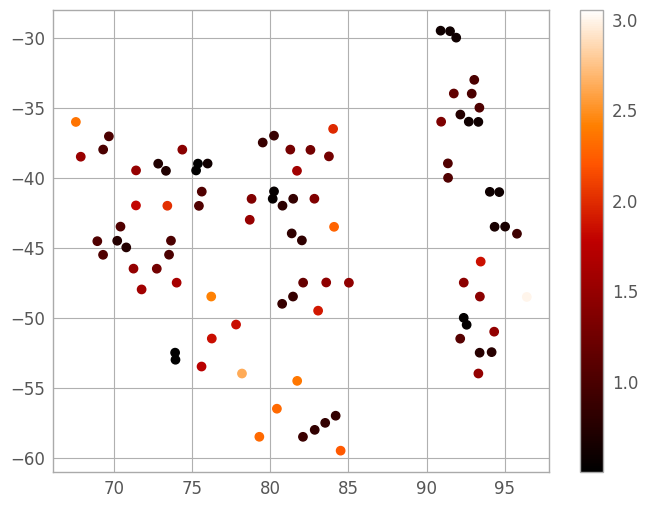

In [24]:
plt.scatter(unique_df['right_ascension'], unique_df['declination'], c=unique_df['nearest_distance'])
plt.colorbar()

50
1.0146013584595586


Text(0.5, 1.0, 'First 50 tiles to upload')

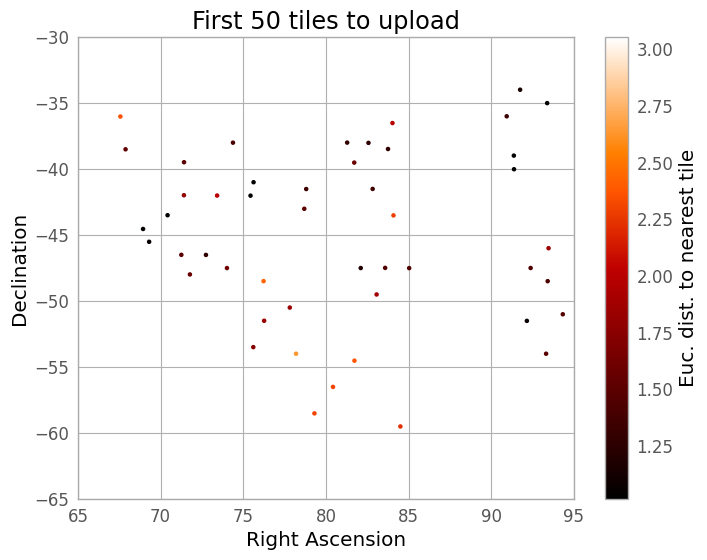

In [29]:
safe_df = unique_df.sort_values('nearest_distance', ascending=False)[:50]

plt.scatter(safe_df['right_ascension'], safe_df['declination'], c=safe_df['nearest_distance'], s=5)
plt.colorbar(label='Euc. dist. to nearest tile')
print(len(safe_df))
plt.ylim([-65, -30])
plt.xlim([65, 95])
print(safe_df['nearest_distance'].min())
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('First 50 tiles to upload')

In [14]:
safe_df['tile_index'].unique()

array([102015620, 102021061, 102016036, 102021034, 102015615, 102034406,
       102012400, 102013966, 102026083, 102011655, 102027664, 102033849,
       102020090, 102023521, 102018234, 102019150, 102027661, 102016463,
       102022002, 102030421, 102021511, 102031525, 102026603, 102030405,
       102022988, 102016054, 102018712, 102022015, 102022017, 102021057,
       102022027, 102032104, 102028219, 102028213, 102034444, 102032115,
       102022990, 102031550, 102032117, 102022013, 102036817, 102018254,
       102025018, 102023993, 102027667, 102028753, 102029879, 102030997,
       102026063, 102035627])

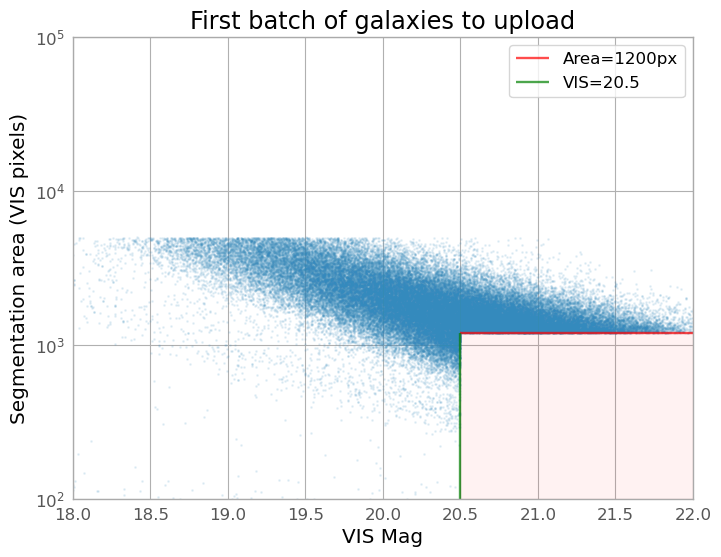

In [ ]:

fig, ax = plt.subplots()
ax.scatter(master_catalog['mag_segmentation'], master_catalog['segmentation_area'], alpha=.1, s=1.)
ax.set_yscale('log')
plt.xlabel('VIS Mag')
plt.ylabel('Segmentation area (VIS pixels)')
x_min = 18
x_max = 22
y_min = 10**2
y_max = 10**5
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.hlines(1200, 20.5, x_max, linestyle='-', alpha=.7, color='r', label='Area=1200px')
ax.vlines(20.5, y_min, 1200, linestyle='-', alpha=.7, color='g', label='VIS=20.5')

alpha = .05
color = 'r'
select_x = np.linspace(x_min, x_max)

select_x = np.linspace(20.5, x_max)
ax.fill_between(select_x, y_min, 1200, color=color, alpha=alpha)
# ax.text(19.1, 400, 'Complete to VIS=20.5')
# ax.text(20.1, 5000, 'Includes faint extended galaxies')
ax.set_title('First batch of galaxies to upload')
plt.legend(loc='upper right')

FileNotFoundError: [Errno 2] No such file or directory: '/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch/tiles/EUC_MER_BGSUB-MOSAIC-VIS_TILE102020561-39E663_20240324T205357.122046Z_00.00.fits'

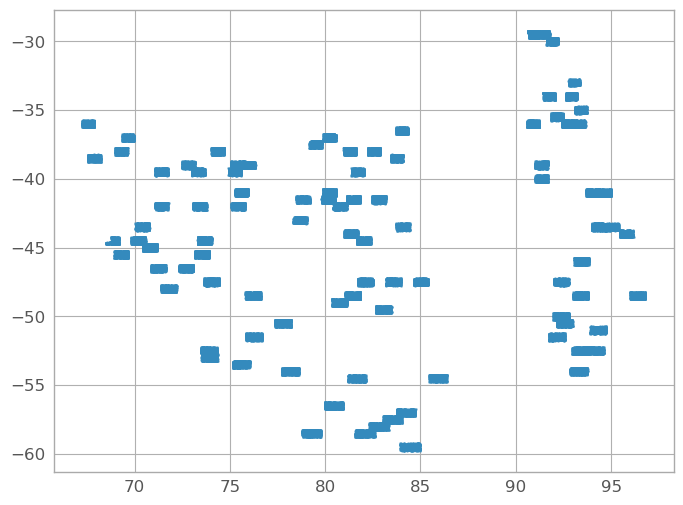

In [ ]:
fig, ax = plt.subplots()

ax.scatter(master_catalog['right_ascension'], master_catalog['declination'], alpha=.5, s=1., label='Galaxies')

# ra_centers = []
# dec_centers = []
# for vis_loc in master_catalog['vis_tile'].unique():
#     _, vis_tile_header = fits.getdata(vis_loc, header=True)
#     w = wcs.WCS(vis_tile_header)
#     # plot center
#     ra_centers.append(vis_tile_header['CRVAL1'])
#     dec_centers.append(vis_tile_header['CRVAL2'])

ra_centers = master_catalog['tile_ra'].unique()
dec_centers = master_catalog['tile_dec'].unique()

ax.scatter(ra_centers, dec_centers, color='r', s=5, label='Tile center')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title('First batch of galaxies to upload')
ax.legend()

In [ ]:
valid_tile_indices = list(master_catalog['tile_index'].unique())
# valid_tile_indices = [102010567]  # good tile
# valid_tile_indices = [102010923]  # good tile
# valid_tile_indices = [102010569]  # bad tile, negative X_CENTER, Y_CENTER on all sources, following up with MER
# valid_tile_indices.sort()
print(f'Tiles to make cutouts from: {len(valid_tile_indices)}')

for tile_n, tile_index in enumerate(valid_tile_indices):
    print(f'Tile {tile_index}, {tile_n}')
    tile_galaxies = master_catalog.query(f'tile_index == {tile_index}')
    print(tile_galaxies[['right_ascension', 'declination']].mean())
    vis_loc = tile_galaxies['vis_tile'].iloc[0]
    nisp_loc = tile_galaxies['y_tile'].iloc[0]
    print(vis_loc)
    pipeline_utils.save_cutouts(cutout_folder, vis_loc, nisp_loc, tile_galaxies, overwrite=False, oneway_hash=False)

Tiles to make cutouts from: 11
Tile 102032104, 0
right_ascension    74.380876
declination       -37.995398
dtype: float64
/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/tiles/EUC_MER_BGSUB-MOSAIC-VIS_TILE102032104-E8A75_20240301T235550.974390Z_00.00.fits
loading tile
tile loaded
galaxy 0 of 1008
skipping galaxy -747073306378041902 in tile 102032104 due to 
cutout low x edge above high x edge: (c1, c2)=(0, -28), cluster_x=-56.64421998080252, mosaic=(19200, 19200)
skipping galaxy -747064682381508837 in tile 102032104 due to 
Shape mismatch: cutout of shape (171, 99) not square
skipping galaxy -747051764377373624 in tile 102032104 due to 
Shape mismatch: cutout of shape (81, 36) not square
skipping galaxy -747050372378252380 in tile 102032104 due to 
Shape mismatch: cutout of shape (56, 40) not square
skipping galaxy -747045324380103902 in tile 102032104 due to 
Shape mismatch: cutout of shape (103, 101) not square
skipping galaxy -747038722378063859 

In [ ]:
tile_galaxies['fits_loc']

0      /home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/cutouts/fits/102026098/102026098_NEG947142893435059063_fits.fits.gz
1      /home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/cutouts/fits/102026098/102026098_NEG947135883436258237_fits.fits.gz
2      /home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/cutouts/fits/102026098/102026098_NEG947135055434365364_fits.fits.gz
3      /home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/cutouts/fits/102026098/102026098_NEG947133315433718651_fits.fits.gz
4      /home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/cutouts/fits/102026098/102026098_NEG947128555436067982_fits.fits.gz
                                                                                 ...                                                                           
914    /home/walml/repos/euclid-morpholo

In [ ]:
# cutout_folder.replace('jpg', 'fits')

In [ ]:
# also save the cutouts as FITS, for other people to tinker with 
# much more space-expensive, but still a lot smaller than the original tiles

# TODO Kristin, could you help me save the coordinates of the cutout in the cutout fits headers? I have the tile WCS but need to adapt it post-tile-slice for each cutout

valid_tile_indices = [102034406]
for tile_n, tile_index in enumerate(valid_tile_indices):
    print(f'Tile {tile_index}, {tile_n}')
    tile_galaxies = master_catalog.query(f'tile_index == {tile_index}')[:100]
    vis_loc = tile_galaxies['vis_tile'].iloc[0]
    nisp_loc = tile_galaxies['y_tile'].iloc[0]
    pipeline_utils.save_cutouts(cutout_folder.replace('jpg', 'fits'), vis_loc, nisp_loc, tile_galaxies, overwrite=True, output_format='fits.gz')

Tile 102034406, 0
loading tile
tile loaded
galaxy 0 of 100


AssertionError: Shape mismatch: cutout of shape (101, 7) not square

In [ ]:
# example_vis, header_vis = fits.getdata('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/cutouts/fits/102010567/102010567_NEG824834966608550243.fits.gz', ext=1, header=True)
# example_y, header_y = fits.getdata('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/cutouts/fits/102010567/102010567_NEG824834966608550243.fits.gz', ext=2, header=True)
# example_vis.shape, example_y.shape

In [ ]:
# fig, axes = plt.subplots(ncols=2)
# axes[0].imshow(np.arcsinh(example_vis * 100))
# axes[1].imshow(np.arcsinh(example_y * 0.2))

In [ ]:
# header_vis

In [ ]:
# header_y

In [ ]:
# cutout_folder

## Package for Export

In [ ]:
# only zip one tile of fits, quite big
shutil.make_archive(
    download_dir + '_fits_cutouts', 
    'zip', 
    cutout_folder.replace('jpg', 'fits')
)

'/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local_fits_cutouts.zip'

In [ ]:
cutout_folder

'/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local/cutouts/jpg'

In [ ]:
download_dir

'/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local'

In [ ]:
# save to e.g. v1_challenge_launch_cutouts.zip
shutil.make_archive(download_dir + '_cutouts', 'zip', cutout_folder)



'/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local_cutouts.zip'

In [ ]:
shutil.make_archive(download_dir + '_catalogs', 'zip', base_catalog_dir)

'/home/walml/repos/euclid-morphology/datalabs/data/pipeline/v2_challenge_launch_local_catalogs.zip'